<h1><center>Projet PDS</center></h1>
Nom: De Gani
Prénom: Guillaume

Le sujet que j'ai choisi d'aborder est la classification de tumeur cérébrale a partir d'IRM contrasté T1. 


L'objectif que je me suis fixé était de développer une analyse concrète et applicable dans le monde réel. Donc les image d'IRM seraient reçues en entrée, la tumeur serait détectée puis segmentée pour en avoir les contours. Une fois la tumeur extraite elle sera ensuite classifiée en utilisant différents algorithmes de classification. Le but de cette classification est de faire une distinction entre 3 tumeurs :
- `Meningiome` Tumeur majoritairement bénigne qui se développe à partir de meninge.
- `Pituitaires` Ces tumeurs peuvent être sécrétantes d'hormones ce qui peut causer des maladie comme le diabète, le gigantisme ou l'acromégalie.
- `Gliome` Les gliomes sont des tumeurs qui sont complexes à étudier car si elles sont malignes le diagnostic est très mauvais. Mais elles peuvent aussi être bénigne.



In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import random as rand
from pylab import *
import matplotlib.patches as mpatches
from scipy.stats import norm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from random import choice
from PIL import Image
import skimage.measure
from skimage.color import rgb2gray
from skimage.color import rgba2rgb
import imageio
!pip install mat73
!pip install Image

#Récupération des données
Avant d'entrainer notre modèle il fallait diviser les images en trois sur les trois coupe différentes :
- `Axiale`
- `Coronale`
- `Sagittale`

In [ ]:
import os
import mat73
data = []
name_files = []
for filename in os.listdir(r"D:\Users\Guillaume\Desktop\Brain Tumor Segmenation and Classification\data"):
    if filename.endswith("mat"):
      data.append(mat73.loadmat(r'D:\Users\Guillaume\Desktop\Brain Tumor Segmenation and Classification\data\\' + filename))
      name_files.append(filename[: len(filename) - 4] + '.png')

In [ ]:
input_img_prov = []
for f in data:
  input_img_prov.append(f['cjdata']['image'])

target_img_prov = []
for f in data:
  target_img_prov.append(f['cjdata']['tumorMask'])

labels_prov = []
for f in data:
  labels_prov.append(f['cjdata']['label'])

labels = np.asarray(labels_prov,dtype='int')
input_img = np.asarray(input_img_prov)
target_img = np.asarray(target_img_prov)


C:\Users\gui_m\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#Segmentation de la tumeur

Ce code sert à créer un modèle U-Net qui est un modèle fréquemment utilisé pour la segmentation d'image où l'objet a détecter est petit, ce qui est le cas dans cette étude. 

Pour ce genre de problème le choix du scoring metrics est très important car dans ce cas si on se sert de l'accuracy le modèle pourrait simplement tout labéliser en non-tumeur et il aurait une précision très élevée. Du coup le choix que j'ai fait était d'utiliser le Dice-Score qui est souvent utilisé dans ces genre de problème de classification. 

La formule étant :

$$Dice = \frac{2\times TP}{(TP+FP) + (TP+FN)}$$ 

Avec :

`TP` True positve

`FP` False Positive

`FN` False Negative


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\gui_m\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/17
24/24 [==============================] - 58s 2s/step - loss: 0.9698 - iou_score: 0.0183 - f1-score: 0.0356 - val_loss: 0.9555 - val_iou_score: 0.0205 - val_f1-score: 0.0400
Epoch 2/17
24/24 [==============================] - 40s 2s/step - loss: 0.9630 - iou_score: 0.0217 - f1-score: 0.0421 - val_loss: 0.9520 - val_iou_score: 0.0350 - val_f1-score: 0.0670
Epoch 3/17
24/24 [==============================] - 39s 2s/step - loss: 0.9583 - iou_score: 0.0239 - f1-score: 0.0463 - val_loss: 0.9484 - val_iou_score: 0.0404 - val_f1-score: 0.0768
Epoch 4/17
24/24 [==============================] - 38s 2s/step - loss: 0.9551 - iou_score: 0.0254 - f1-score: 0.0493 - val_loss: 0.9441 - val_iou_score: 0.0407 - val_f1-score: 0.0772
Epoch 5/17
24/24 [==============================] - 38s 2s/step - loss: 0.9519 - iou_score: 0.0272 - f1-score: 0.0526 - val_loss: 0.9413 - val_iou_score: 0.0359 - val_f1-score: 0.0685
Epoch 6/17
24/24 [==============================] - 40s 2s/step - loss: 0.9485 -

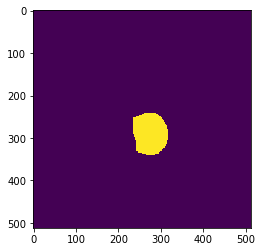

In [ ]:
import os
from IPython.display import Image, display
import PIL
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import load_img

from PIL import Image
#for i in range(len(target_img_paths_prov)):
#    (Image.fromarray(target_img_paths_prov[i])).save('tumor_mask%i' % i + '.png' )

input_dir = r'C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\Axiale'
target_dir = r'C:\Users\gui_m\.spyder-py3\circDeep-master\Masks'      
img_size = (512, 512)
num_classes = 2
batch_size = 8


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)  
        if fname.endswith(".png") and not fname.startswith(".")
    ]   
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".") and ((input_dir+ '\\' + fname) in input_img_paths)
    ]
)
   
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

#Creation of data class to improve performace of further learning
class tumorSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)/255
        return x, y


from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
            )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, (1,1),activation = "sigmoid", padding="same")(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    
    
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

import random
import tensorflow as tf

from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)
# Split our img paths into a training and a validation set
val_samples = 800
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = tumorSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = tumorSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)
plt.imshow(val_gen.__getitem__(0)[0][3].astype('uint8'),interpolation='nearest')
plt.imshow(val_gen.__getitem__(0)[1][3].astype('uint8'),interpolation='nearest')

#Création de fonction de perte personalisé qui corespond a notre pobleme
def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.
    
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice
    
    
def jaccard_distance(y_true, y_pred, smooth=1000):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)*100    
    
    
import segmentation_models as sm

#Combinaison entre deux fontion de perte pour l'entrainement du modele
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metricst = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
   
from keras.optimizer_v2.adam import Adam

testIoU = sm.metrics.IOUScore

model.compile(optimizer = Adam(lr = 1e-6), loss=total_loss, metrics = metricst )


epochs = 17
    
model.fit(train_gen, epochs=epochs, validation_data=val_gen)   

val_gen = tumorSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def test(a):
    s = (512,512)
    out = np.zeros(s)
    for i in range(512):
        for j in range(512):
           if( a[i][j][0] >0.75):
               out[i][j] = 1
           else:
               out[i][j] = 0
    return out



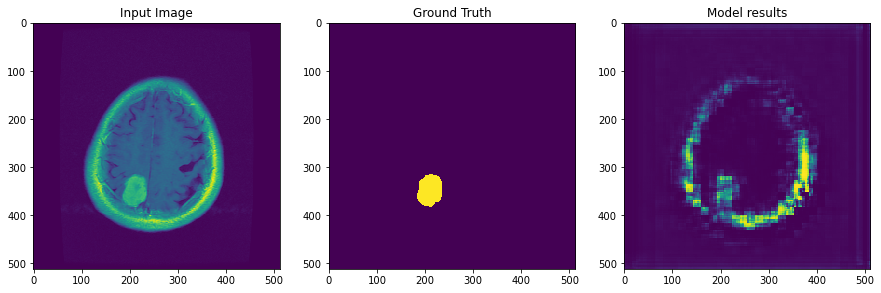

In [ ]:
idx=4
f, axarr = plt.subplots(1,3)
f.set_size_inches(15, 15)
axarr[0].set_title("Input Image")
axarr[1].set_title("Ground Truth")
axarr[2].set_title("Model results")
axarr[0].imshow(val_gen.__getitem__(idx//8)[0][idx%8].astype('uint8'),interpolation='nearest')
axarr[1].imshow(val_gen.__getitem__(idx//8)[1][idx%8].astype('uint8'),interpolation='nearest')
axarr[2].imshow(val_preds[idx],interpolation='nearest')


Les résultats ne sont pas très précis cela peuvent être causés par plusieure choses notamment la taille assez faible du jeu de données utilisé pour l'apprentissage. En effet il y a seulement 1000 images pour entrainer un modèle avec plus de 2 Millions de paramètres. 
D'autre part le crâne fait beaucoup d'interférences en effet le modèle a du mal à faire la distinction entre des tumeurs et le crâne. 
Pour résoudre ce problème il aurait été possible de faire une étape de `Brain exctraction` en utilisant le niveau de luminosité élevé du crâne. 
Cependant je n'ai pas eu le temps d'implémenter cette étape.
Enfin il aurait été possible de faire de la data augmentation pour améliorer la précision du modèle ; mais encore un fois cette étape demande beaucoup de temps à implémenter.


#Création de features

Avant de commencer la classification il faut faire une étape de feature extraction. Pour se faire il faut le mask pour savoir où est la tumeur. Puisque que le modele que j'ai implémenté fonctionne de manière aproximative j'ai decidé d'utliser les mask fournis dans le jeu de données pour quand meme avoir des résultats cohérents au niveau de la classifitcation.


In [ ]:
"Creation de fonction qui extrait différent features"
#Extrait tout les points appartenant a la tumeur
def getPointsInMatric(mat):
  out = []
  for y in range(len(mat)):
    for x in range(len(mat[y])):
      if(mat[y][x]):
        out.append((x,y))
  return out
#Fonction pour trouvé la largeur et hauteur de la tumeur
def getDimensions(mat):
    x_min,x_max,y_min,y_max = 512,0,512,0
    for i in range(len(mat)):
          for j in range(len(mat[i])):
            if(mat[i][j]):
              if(i < x_min):
                x_min = i
              if(j < y_min):
                y_min = j
              if(i > x_max):
                x_max = i
              if(j > y_max):
                y_max = j  
    return (x_max-x_min,y_max-y_min)
#Posistion moyenne de la tumeur
def getAvgPos(mat):
  avgX = 0
  avgY = 0
  counter = 0
  for y in range(len(mat)):
    for x in range(len(mat[y])):
      if(mat[y][x]):
        avgX += x
        avgY += y
        counter +=1
  return (avgX/counter,avgY/counter)
#Position moyenne en X
def getAvgX(mat):
  return getAvgPos(mat)[0]
#Position moyenne en Y
def getAvgY(mat):
  return getAvgPos(mat)[1]
#Largeur de la tumeur
def getWidth(mat):
  return getDimensions(mat)[0]
#Hauteur de la tumeur
def getHeight(mat):
  return getDimensions(mat)[1]
#Rapport entre la hauteur et la largeur pour voir si la tumeur est circulaire
def getRatio(mat):
  prov = getDimensions(mat)
  return min(prov)/max(prov)
#Calcul de la taille de la tumeur
def getSurface(mat):
    out = 0
    for rows in mat:
      out += np.count_nonzero(rows == True)
    return out

In [ ]:
  #Fonction qui extrait la liste de features d'une certaine coupe
  #f: La fonction calculant le feature
  #slice: La coupe choisi
  def appendFromSlice(f,slice='Axiale'):
    prov = [[],[],[]]
    for i in range(len(labels)):
      if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % slice):
        label = labels[i]
        prov[label-1].append(f(target_img[i]))
    return prov




In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]


Meningioma_points_train_axiale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Axiale')[0]))
Glioma_points_train_axiale =np.array(flatten(appendFromSlice(getPointsInMatric,slice='Axiale')[1]))
Pituitary_points_train_axiale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Axiale')[2]))


Meningioma_points_train_Sagittale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Sagittale')[0]))
Glioma_points_train_Sagittale =np.array(flatten(appendFromSlice(getPointsInMatric,slice='Sagittale')[1]))
Pituitary_points_train_Sagittale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Sagittale')[2]))


Meningioma_points_train_Coronale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Coronale')[0]))
Glioma_points_train_Coronale =np.array(flatten(appendFromSlice(getPointsInMatric,slice='Coronale')[1]))
Pituitary_points_train_Coronale = np.array(flatten(appendFromSlice(getPointsInMatric,slice='Coronale')[2]))



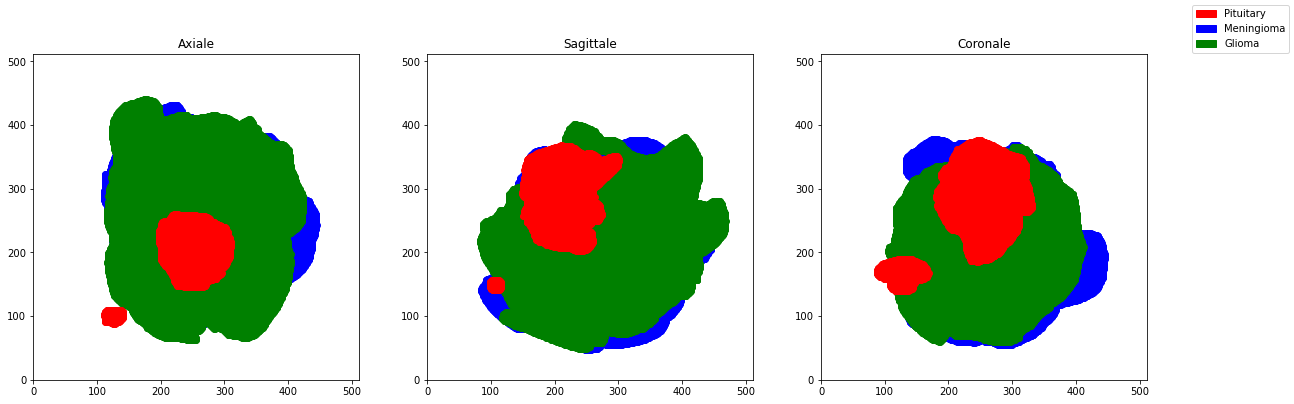

In [ ]:

fig = plt.figure(figsize=(20,6))

red_patch = mpatches.Patch(color='red', label='Pituitary')
blue_patch = mpatches.Patch(color='blue', label='Meningioma')
green_patch = mpatches.Patch(color='green', label='Glioma')

fig.legend(handles=[red_patch,blue_patch,green_patch])
ax1 = fig.add_subplot(131,aspect='equal')
ax2 = fig.add_subplot(132,aspect='equal')
ax3 = fig.add_subplot(133,aspect='equal')
ax1.set_title('Axiale')
ax2.set_title('Sagittale')
ax3.set_title('Coronale')

ax1.set_xlim([0,512])
ax1.set_ylim([0,512])
ax2.set_xlim([0,512])
ax2.set_ylim([0,512])
ax3.set_xlim([0,512])
ax3.set_ylim([0,512])
ax1.scatter(*Meningioma_points_train_axiale.T,c="blue")
ax1.scatter(*Glioma_points_train_axiale.T,c="green")
ax1.scatter(*Pituitary_points_train_axiale.T,c="red")
ax2.scatter(*Meningioma_points_train_Sagittale.T,c="blue")
ax2.scatter(*Glioma_points_train_Sagittale.T,c="green")
ax2.scatter(*Pituitary_points_train_Sagittale.T,c="red")
ax3.scatter(*Meningioma_points_train_Coronale.T,c="blue")
ax3.scatter(*Glioma_points_train_Coronale.T,c="green")
ax3.scatter(*Pituitary_points_train_Coronale.T,c="red")
plt.show()

#Visualisation des données

In [ ]:
areas_list = appendFromSlice(getSurface)
Meningioma_area = np.array(areas_list[0])
Glioma_points_area = np.array(areas_list[1])
Pituitary_points_area = np.array(areas_list[2])

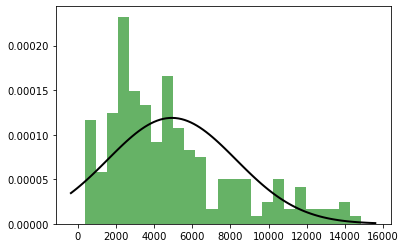

In [ ]:

plt.hist(Meningioma_area,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(Meningioma_area)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()


(array([1.81937941e-04, 7.88636183e-04, 1.72996488e-03, 2.42984682e-03,
        3.16920872e-03, 3.97957951e-03, 3.84540268e-03, 3.83629616e-03,
        4.19356912e-03, 3.84798883e-03, 3.89808848e-03, 4.41903130e-03,
        4.76832574e-03, 5.86110890e-03, 5.93877574e-03, 5.86564840e-03,
        5.95321962e-03, 4.79666327e-03, 3.95674441e-03, 3.35376031e-03,
        2.21709525e-03, 1.19501836e-03, 4.98327828e-04, 1.42292913e-04,
        3.96175163e-05]),
 array([115.  , 127.36, 139.72, 152.08, 164.44, 176.8 , 189.16, 201.52,
        213.88, 226.24, 238.6 , 250.96, 263.32, 275.68, 288.04, 300.4 ,
        312.76, 325.12, 337.48, 349.84, 362.2 , 374.56, 386.92, 399.28,
        411.64, 424.  ]),
 <BarContainer object of 25 artists>)

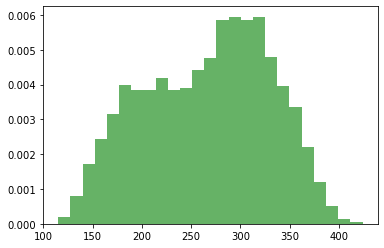

In [ ]:
hits2 = [i[0] for i in Glioma_points_train_axiale]
plt.hist(hits2,bins=25, density=True, alpha=0.6, color='g')

(array([0.00014935, 0.00050621, 0.00109282, 0.00158745, 0.00215664,
        0.00343248, 0.00450286, 0.00538532, 0.00579561, 0.00519209,
        0.00514719, 0.00510601, 0.00444418, 0.00466897, 0.00414759,
        0.00391829, 0.00391697, 0.00375757, 0.00341812, 0.00278814,
        0.00152053, 0.00086585, 0.00072349, 0.00046671, 0.00015985]),
 array([111.  , 124.36, 137.72, 151.08, 164.44, 177.8 , 191.16, 204.52,
        217.88, 231.24, 244.6 , 257.96, 271.32, 284.68, 298.04, 311.4 ,
        324.76, 338.12, 351.48, 364.84, 378.2 , 391.56, 404.92, 418.28,
        431.64, 445.  ]),
 <BarContainer object of 25 artists>)

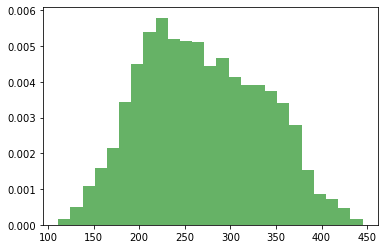

In [ ]:
hits1 = [i[0] for i in Meningioma_points_train_axiale]
plt.hist(hits1,bins=25, density=True, alpha=0.6, color='g')

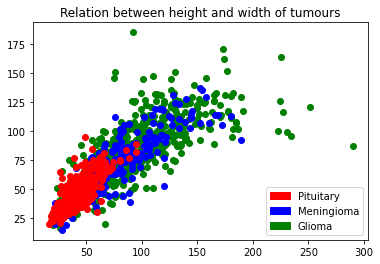

In [ ]:
width_height_list = appendFromSlice(getDimensions)
Meningioma_points_width_height = np.array(width_height_list[0])
Glioma_points_width_height = np.array(width_height_list[1])
Pituitary_points_width_height = np.array(width_height_list[2])
plt.legend(handles=[red_patch,blue_patch,green_patch])
plt.title("Relation between height and width of tumours")
plt.scatter(*Glioma_points_width_height.T,c="green")
plt.scatter(*Meningioma_points_width_height.T,c="blue")
plt.scatter(*Pituitary_points_width_height.T,c="red")

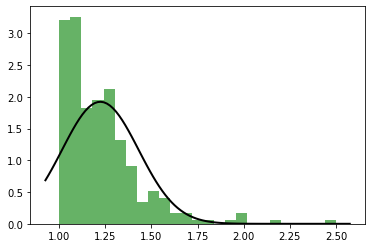

1.2227578242706005 0.20741198291043242


In [ ]:
hits3 = [max([i[0]/i[1],i[1]/i[0]]) for i in Pituitary_points_width_height]
plt.hist(hits3,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(hits3)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)

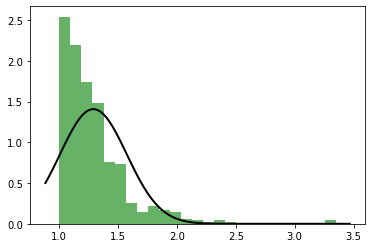

1.2898656110530649 0.2833857772185242


In [ ]:
bite2 = [max([i[0]/i[1],i[1]/i[0]]) for i in Glioma_points_width_height]
plt.hist(bite2,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(bite2)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)

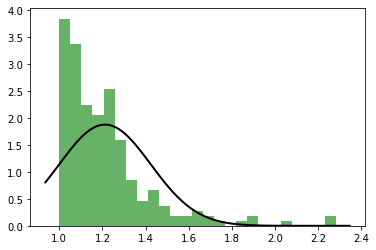

1.2119605728404894 0.2123314254322687


In [ ]:
bite2 = [max([i[0]/i[1],i[1]/i[0]]) for i in Meningioma_points_width_height]
plt.hist(bite2,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(bite2)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)


In [ ]:

df = pd.DataFrame()
df_Sagittale = pd.DataFrame()
df_Coronale = pd.DataFrame()

#Fonction qui extrait la liste numpy de features d'une certaine coupe
#f: La fonction calculant le feature
#slice: La coupe choisi
def appendFromSliceAsNpArray(f,slice='Axiale'):
  prov = []
  for i in range(len(labels)):
    if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % slice):
      prov.append(f(target_img[i]))
  return np.asarray(prov)

df_Sagittale['width'] = appendFromSliceAsNpArray(getWidth,"Sagittale")
df['width'] = appendFromSliceAsNpArray(getWidth)
df_Coronale['width'] =appendFromSliceAsNpArray(getWidth,"Coronale")

In [ ]:
df['height'] = appendFromSliceAsNpArray(getHeight)
df['avgPosX'] = appendFromSliceAsNpArray(getAvgX)
df['avgPosY'] = appendFromSliceAsNpArray(getAvgY)
df['ratioCircular'] = appendFromSliceAsNpArray(getRatio)
df['area'] = appendFromSliceAsNpArray(getSurface)

df_Sagittale['height'] = appendFromSliceAsNpArray(getHeight,"Sagittale")
df_Sagittale['avgPosX'] = appendFromSliceAsNpArray(getAvgX,"Sagittale")
df_Sagittale['avgPosY'] = appendFromSliceAsNpArray(getAvgY,"Sagittale")
df_Sagittale['ratioCircular'] = appendFromSliceAsNpArray(getRatio,"Sagittale")
df_Sagittale['area'] = appendFromSliceAsNpArray(getSurface,"Sagittale")

df_Coronale['height'] = appendFromSliceAsNpArray(getHeight,"Coronale")
df_Coronale['avgPosX'] = appendFromSliceAsNpArray(getAvgX,"Coronale")
df_Coronale['avgPosY'] = appendFromSliceAsNpArray(getAvgY,"Coronale")
df_Coronale['ratioCircular'] = appendFromSliceAsNpArray(getRatio,"Coronale")
df_Coronale['area'] = appendFromSliceAsNpArray(getSurface,"Coronale")



Voici les premières feature extraites et la logique derrière leur choix :
- `Width` la largeur de la tumeur qui donne
- `Height` la hauteur de la tumeur
- `avgPosX` position moyenne en X
- `avgPosY` position moyenne en Y 
- `ratioCircular` le rapport entre la hauteur et la largeur de la tumeur
- `area` le nombre de pixel que comporte le mask ce qui donne une surface

Les paramètres `Width`, `Height` et `ratioCircular` donnent des indications sur la forme de la tumeur. Ensuite, `avgPosX` et `avgPosY` donnent des indications sur la position de la tumeur dans le cerveau. Puis `Width`, `Height` et `area` donne des indication sur la taille de la tumeur. 


In [ ]:
labels_axiale = []
labels_Sagittale = []
labels_Coronale = []

for i in range(len(labels)):
      if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % "Axiale"):
        labels_axiale.append(labels[i])
for i in range(len(labels)):
      if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % "Sagittale"):
        labels_Sagittale.append(labels[i])
for i in range(len(labels)):
      if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % "Coronale"):
        labels_Coronale.append(labels[i])

df['Label'] = np.asarray(labels_axiale)
df_Sagittale['Label'] = np.asarray(labels_Sagittale)
df_Coronale['Label'] = np.asarray(labels_Coronale)

In [ ]:
X_Axiale = df.drop(columns=['Label'],axis=1)
Y_Axiale = df['Label'].values

X_Sagittale = df_Sagittale.drop(columns=['Label'],axis=1)
Y_Sagittale = df_Sagittale['Label'].values

X_Coronale = df_Coronale.drop(columns=['Label'],axis=1)
Y_Coronale = df_Coronale['Label'].values

X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)
X_Sagittale_train,X_Sagittale_test,Y_Sagittale_train,Y_Sagittale_test = train_test_split(X_Sagittale,Y_Sagittale,test_size=0.20,random_state=20)
X_Coronale_train,X_Coronale_test,Y_Coronale_train,Y_Coronale_test = train_test_split(X_Coronale,Y_Coronale,test_size=0.20,random_state=20)


In [ ]:

#Random Forest Coupe Axiale
model_forest_Axiale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = model_forest_Axiale.predict(X_Axiale_test)

#Random Forest Coupe Sagittale
model_forest_Sagittale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = model_forest_Sagittale.predict(X_Sagittale_test)

#Random Forest Coupe Coronale
model_forest_Coronale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = model_forest_Coronale.predict(X_Coronale_test)




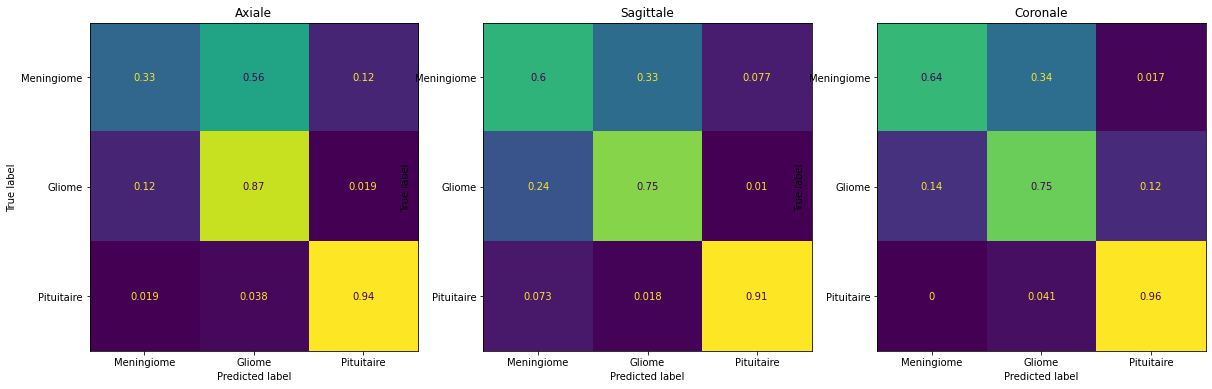

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(model_forest_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(model_forest_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(model_forest_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

Dans le diagrame ci-dessus on remarque tout d'abord que le modèle arrive assez facilement à distingue les `Meningiome` et `Gliome` des tumeurs `Pituitaire` se qu'on peut expliquer par leur différence en taille et leur position dans le cerveau. 

<BarContainer object of 6 artists>

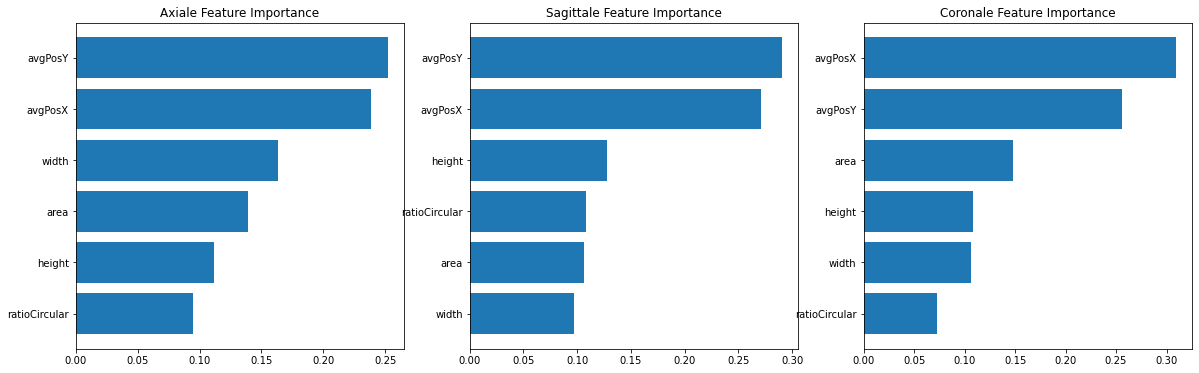

In [ ]:
idx=4
f, axarr = plt.subplots(1,3)
f.set_size_inches(20, 6)

feature_names = X_Axiale.columns
sorted_idx_Axiale = model_forest_Axiale.feature_importances_.argsort()
sorted_idx_Sagittale = model_forest_Sagittale.feature_importances_.argsort()
sorted_idx_Coronale = model_forest_Coronale.feature_importances_.argsort()
axarr[0].set_title("Axiale Feature Importance")
axarr[1].set_title("Sagittale Feature Importance")
axarr[2].set_title("Coronale Feature Importance")
axarr[0].barh(feature_names[sorted_idx_Axiale], model_forest_Axiale.feature_importances_[sorted_idx_Axiale])
axarr[1].barh(feature_names[sorted_idx_Sagittale], model_forest_Sagittale.feature_importances_[sorted_idx_Sagittale])
axarr[2].barh(feature_names[sorted_idx_Coronale], model_forest_Coronale.feature_importances_[sorted_idx_Coronale])

In [ ]:


linear_Axiale = svm.SVC(kernel='linear').fit(X_Axiale_train, Y_Axiale_train)
poly_Axiale = svm.SVC(kernel='poly', degree=3).fit(X_Axiale_train, Y_Axiale_train)
poly_Axiale_pred = poly_Axiale.predict(X_Axiale_test)

linear_Coronale = svm.SVC(kernel='linear').fit(X_Coronale_train, Y_Coronale_train)
poly_Coronale = svm.SVC(kernel='poly', degree=2).fit(X_Coronale_train, Y_Coronale_train)
poly_Coronale_pred = poly_Coronale.predict(X_Coronale_test)

linear_Sagittale = svm.SVC(kernel='linear').fit(X_Sagittale_train, Y_Sagittale_train)
poly_Sagittale = svm.SVC(kernel='poly', degree=2).fit(X_Sagittale_train, Y_Sagittale_train)
poly_Sagittale_pred = poly_Sagittale.predict(X_Sagittale_test)




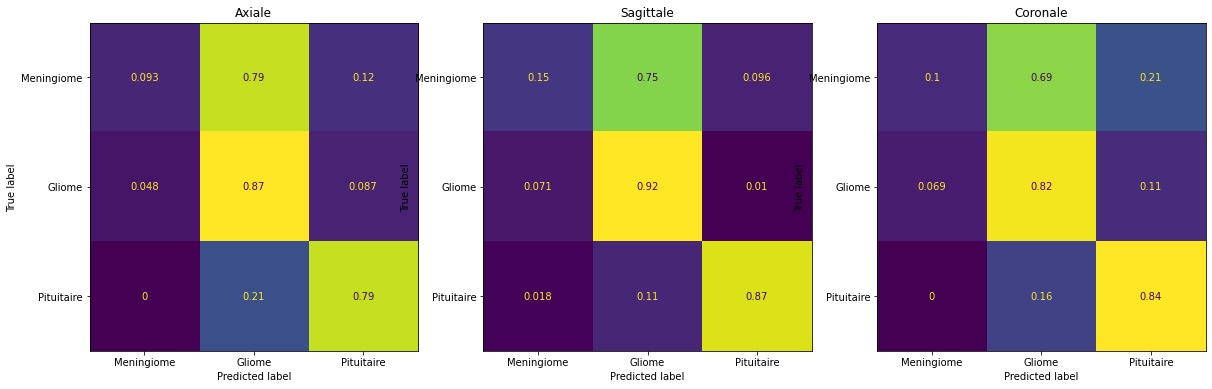

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(linear_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(linear_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(linear_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

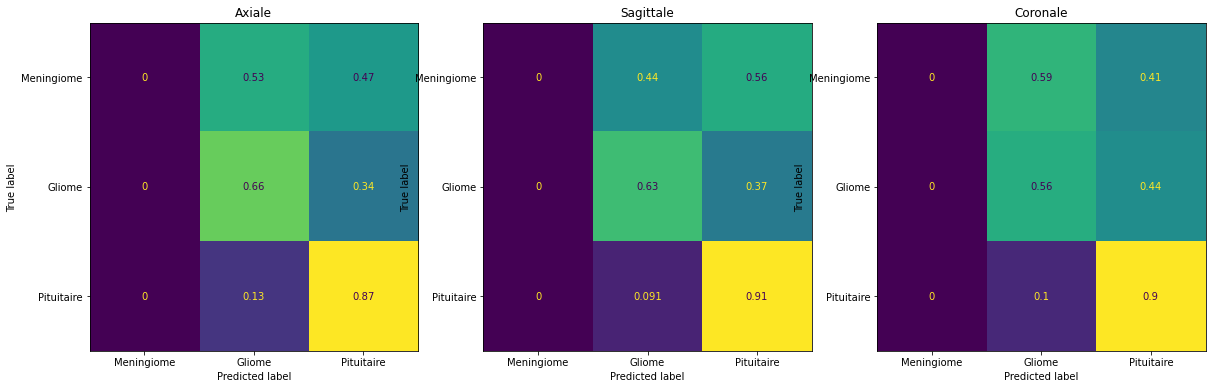

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(poly_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(poly_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(poly_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

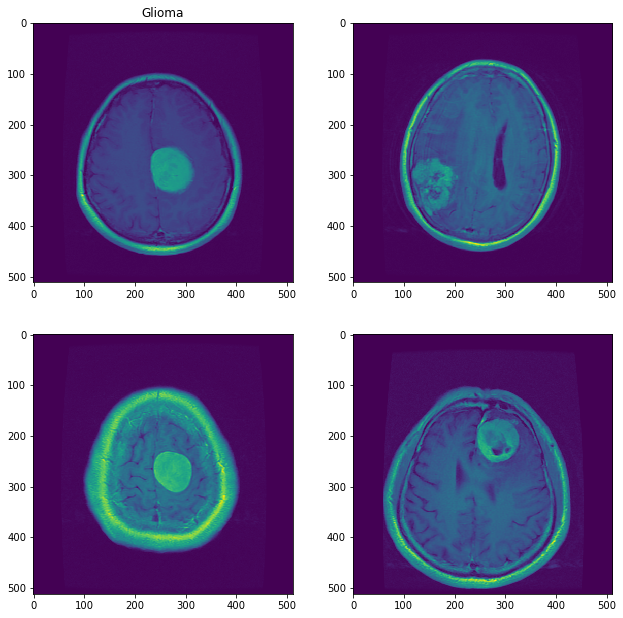

In [ ]:
f, axarr = plt.subplots(2,2)
f.set_size_inches(10.5, 10.5)
id1=  imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\Axiale\11.png")
id2=  imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\Axiale\106.png")
id3=  imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\Axiale\61.png")
id4=  imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\Axiale\63.png")
axarr[0,0].set_title('Glioma')
axarr[0,0].imshow(id1,interpolation='nearest')
axarr[0,1].imshow(id2,interpolation='nearest')
axarr[1,0].imshow(id3,interpolation='nearest')
axarr[1,1].imshow(id4,interpolation='nearest')

On remarque que les différents modèles confondent les Gliome et les Meningiome il faut donc trouver un nouveau feature qui permet de distinguer entre ces deux types de tumeurs.
En lisant des articles sur les tumeurs on apprend que les Gliomes ne sont pas uniformes. En effet leur partie intérieure est `Nécrosé` ce qui explique les tâches noires à l'interieur des tumeurs sur les images à droite.
Donc un nouveau paramètre est introduit : l'entropy de la tumeur qui est une mesure de son uniformité. 

In [ ]:
def getEntropy(mat,imgArray):
  provOut = []
  for x in range(len(mat)):
    for y in range(len(mat[x])):
      if(mat[x][y]):
        provOut.append(imgArray[x][y][0]*0.2989+imgArray[x][y][1]*0.5780+imgArray[x][y][2]*0.1140)
  entropy = skimage.measure.shannon_entropy(provOut)  
  return entropy


def appendFromSliceEntropy(f,slice='Axiale'):
  prov = [[],[],[]]
  for i in range(len(labels)):
    if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % slice):
      label = labels[i]
      prov[label-1].append(f(target_img[i],imageio.imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s\%s" % (slice,name_files[i]))))
  return prov

In [ ]:
entropy_list_Axiale = appendFromSliceEntropy(getEntropy)
Meningioma_entropy_list_Axiale = np.array(entropy_list_Axiale[0])
Glioma_entropy_list_Axiale = np.array(entropy_list_Axiale[1])
Pituitary_entropy_list_Axiale = np.array(entropy_list_Axiale[2])



In [ ]:
entropy_list_Sagittale = appendFromSliceEntropy(getEntropy,'Sagittale')
Meningioma_entropy_list_Sagittale = np.array(entropy_list_Sagittale[0])
Glioma_entropy_list_Sagittale = np.array(entropy_list_Sagittale[1])
Pituitary_entropy_list_Sagittale = np.array(entropy_list_Sagittale[2])

entropy_list_Coronale = appendFromSliceEntropy(getEntropy,'Coronale')
Meningioma_entropy_list_Coronale = np.array(entropy_list_Coronale[0])
Glioma_entropy_list_Coronale = np.array(entropy_list_Coronale[1])
Pituitary_entropy_list_Coronale = np.array(entropy_list_Coronale[2])

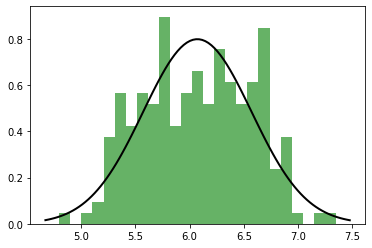

6.071629568527726 0.5000392107358076


In [ ]:
plt.hist(Meningioma_entropy_list,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(Meningioma_entropy_list)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)

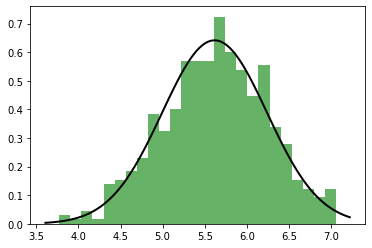

5.616408986201068 0.6218955392017085


In [ ]:
plt.hist(Glioma_entropy_list,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(Glioma_entropy_list)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)

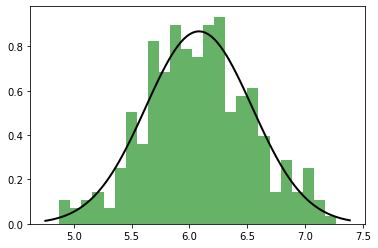

6.081796908820478 0.45950455284719444


In [ ]:
plt.hist(Pituitary_entropy_list,bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
mu, std = norm.fit(Pituitary_entropy_list)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu,std)

In [ ]:
def appendFromSliceAsNpArrayEntropy(f,slice='Axiale'):
  prov = []
  for i in range(len(labels)):
    if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % slice):
      prov.append(f(target_img[i],imageio.imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s\%s"% (slice,name_files[i]))))
  return np.asarray(prov)

In [ ]:
df['entropy'] =  appendFromSliceAsNpArrayEntropy(getEntropy)
df_Sagittale['entropy'] =  appendFromSliceAsNpArrayEntropy(getEntropy,'Sagittale')
df_Coronale['entropy'] =  appendFromSliceAsNpArrayEntropy(getEntropy,'Coronale')


In [ ]:

X_Axiale = df.drop(columns=['Label'],axis=1)
Y_Axiale = df['Label'].values

X_Sagittale = df_Sagittale.drop(columns=['Label'],axis=1)
Y_Sagittale = df_Sagittale['Label'].values

X_Coronale = df_Coronale.drop(columns=['Label'],axis=1)
Y_Coronale = df_Coronale['Label'].values


X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)
X_Sagittale_train,X_Sagittale_test,Y_Sagittale_train,Y_Sagittale_test = train_test_split(X_Sagittale,Y_Sagittale,test_size=0.20,random_state=20)
X_Coronale_train,X_Coronale_test,Y_Coronale_train,Y_Coronale_test = train_test_split(X_Coronale,Y_Coronale,test_size=0.20,random_state=20)

In [ ]:
#Random Forest Coupe Axiale
model_forest_Axiale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = model_forest_Axiale.predict(X_Axiale_test)

#Random Forest Coupe Sagittale
model_forest_Sagittale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = model_forest_Sagittale.predict(X_Sagittale_test)

#Random Forest Coupe Coronale
model_forest_Coronale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = model_forest_Coronale.predict(X_Coronale_test)


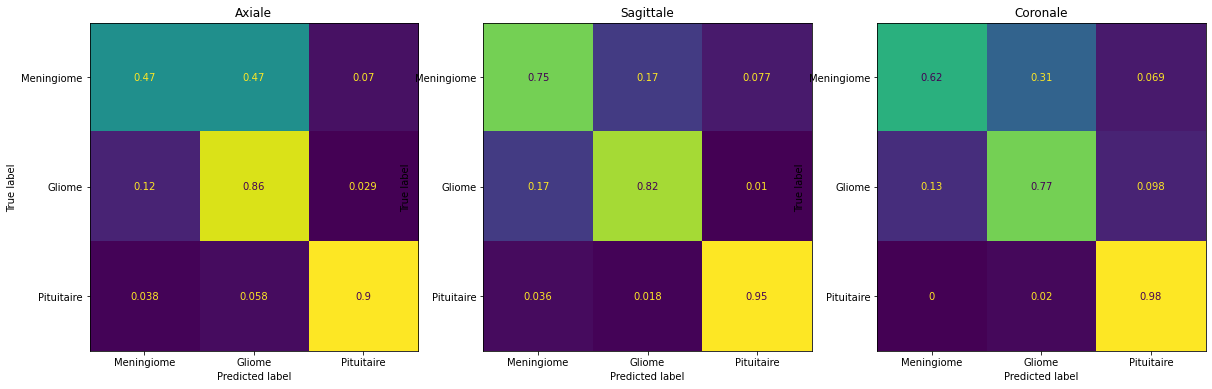

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(model_forest_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(model_forest_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(model_forest_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

On remarque quand rajoutant l'entropy la distinction entre les meningiome et les gliome se fait mieux.

<BarContainer object of 7 artists>

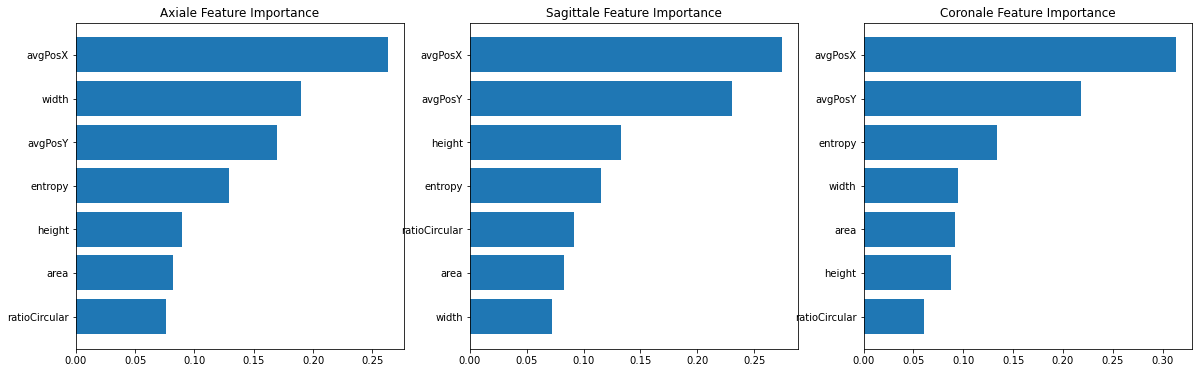

In [ ]:
f, axarr = plt.subplots(1,3)
f.set_size_inches(20, 6)

feature_names = X_Axiale.columns
sorted_idx_Axiale = model_forest_Axiale.feature_importances_.argsort()
sorted_idx_Sagittale = model_forest_Sagittale.feature_importances_.argsort()
sorted_idx_Coronale = model_forest_Coronale.feature_importances_.argsort()
axarr[0].set_title("Axiale Feature Importance")
axarr[1].set_title("Sagittale Feature Importance")
axarr[2].set_title("Coronale Feature Importance")
axarr[0].barh(feature_names[sorted_idx_Axiale], model_forest_Axiale.feature_importances_[sorted_idx_Axiale])
axarr[1].barh(feature_names[sorted_idx_Sagittale], model_forest_Sagittale.feature_importances_[sorted_idx_Sagittale])
axarr[2].barh(feature_names[sorted_idx_Coronale], model_forest_Coronale.feature_importances_[sorted_idx_Coronale])

In [ ]:
from sklearn import tree
#Random Forest Coupe Axiale
dec_tree_Axiale = tree.DecisionTreeClassifier(random_state=20)
dec_tree_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = dec_tree_Axiale.predict(X_Axiale_test)
 
#Random Forest Coupe Sagittale
dec_tree_Sagittale = tree.DecisionTreeClassifier(random_state=20)
dec_tree_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = dec_tree_Sagittale.predict(X_Sagittale_test)
 
#Random Forest Coupe Coronale
dec_tree_Coronale = tree.DecisionTreeClassifier(random_state=20)
dec_tree_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = dec_tree_Coronale.predict(X_Coronale_test)

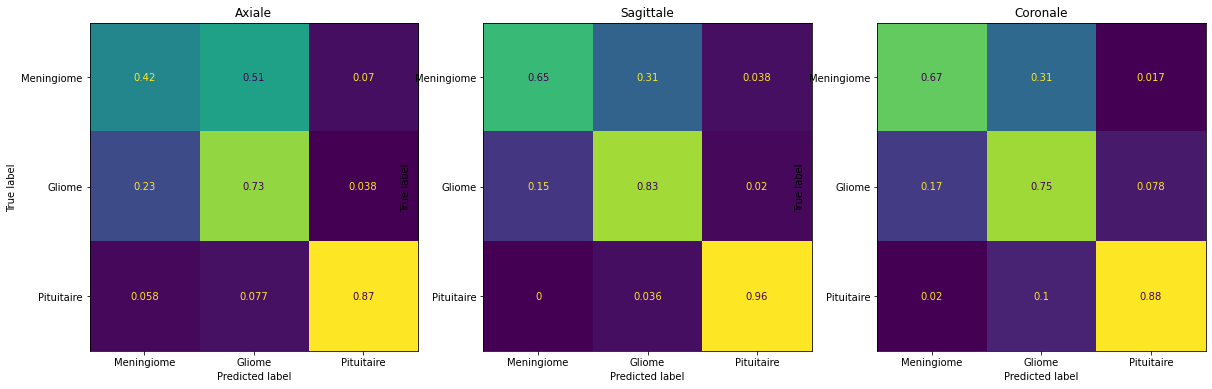

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(dec_tree_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(dec_tree_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(dec_tree_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')

Ci-dessus on teste le decision tree pour le comparer aux random forest. Les résultats sont très similaires donc on utilisera avec préférence le Random Forest qui est plus adaptable.

<BarContainer object of 7 artists>

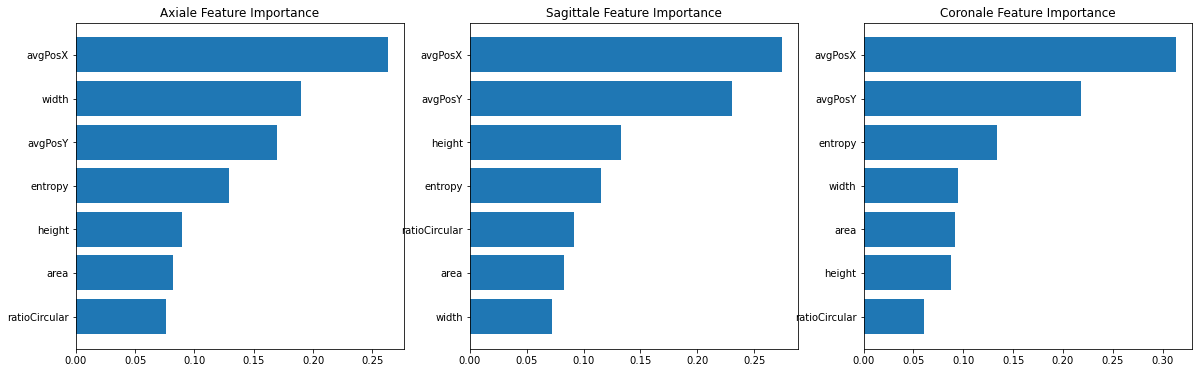

In [ ]:
f, axarr = plt.subplots(1,3)
f.set_size_inches(20, 6)

feature_names = X_Axiale.columns
sorted_idx_Axiale = model_forest_Axiale.feature_importances_.argsort()
sorted_idx_Sagittale = model_forest_Sagittale.feature_importances_.argsort()
sorted_idx_Coronale = model_forest_Coronale.feature_importances_.argsort()
axarr[0].set_title("Axiale Feature Importance")
axarr[1].set_title("Sagittale Feature Importance")
axarr[2].set_title("Coronale Feature Importance")
axarr[0].barh(feature_names[sorted_idx_Axiale], model_forest_Axiale.feature_importances_[sorted_idx_Axiale])
axarr[1].barh(feature_names[sorted_idx_Sagittale], model_forest_Sagittale.feature_importances_[sorted_idx_Sagittale])
axarr[2].barh(feature_names[sorted_idx_Coronale], model_forest_Coronale.feature_importances_[sorted_idx_Coronale])

In [ ]:

# Set the random seed, number of estimators
# and the "step factor" used to plot the graph of MSE
# for each method
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
)
from sklearn.metrics import mean_squared_error
random_state = 42
n_jobs = 1  # Parallelisation factor for bagging, random forests
n_estimators = 1500
step_factor = 5
axis_step = int(n_estimators/step_factor)
estimators = np.zeros(axis_step)
bagging_mse = np.zeros(axis_step)
rf_mse = np.zeros(axis_step)
boosting_mse = np.zeros(axis_step)



for i in range(0, axis_step):
    bagging = BaggingClassifier(
        n_estimators=step_factor*(i+1),
        n_jobs=n_jobs,
        random_state=random_state)
    bagging.fit(X_Axiale_train, Y_Axiale_train)
    mse = f1_score(Y_Axiale_test, bagging.predict(X_Axiale_test),average='macro')
    estimators[i] = step_factor*(i+1)
    bagging_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    rf = RandomForestClassifier(
        n_estimators=step_factor*(i+1),
        n_jobs=n_jobs,
        random_state=random_state
    )
    rf.fit(X_Axiale_train, Y_Axiale_train)
    mse =f1_score(Y_Axiale_test, rf.predict(X_Axiale_test),average='macro')
    estimators[i] = step_factor*(i+1)
    rf_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    boosting = AdaBoostClassifier(
        n_estimators=step_factor*(i+1),
        random_state=random_state,
        learning_rate=1
    )
    boosting.fit(X_Axiale_train, Y_Axiale_train)
    mse = f1_score(Y_Axiale_test, boosting.predict(X_Axiale_test),average='macro')
    estimators[i] = step_factor*(i+1)
    boosting_mse[i] = mse

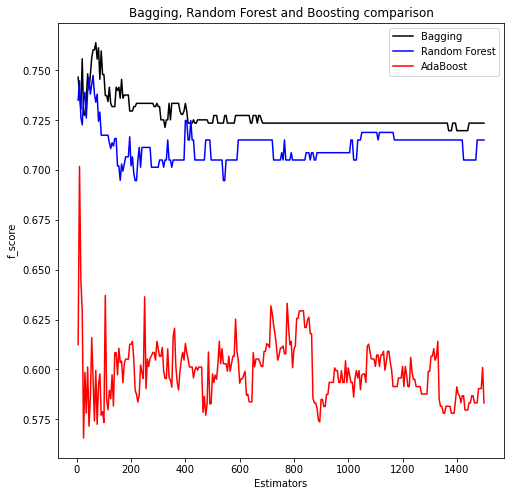

In [ ]:
#Attention ce truc est hyper Long
#Plot the chart of MSE versus number of estimators
plt.figure(figsize=(8, 8))
plt.title('Bagging, Random Forest and Boosting comparison')
plt.plot(estimators, bagging_mse, 'b-', color="black", label='Bagging')
plt.plot(estimators, rf_mse, 'b-', color="blue", label='Random Forest')
plt.plot(estimators, boosting_mse, 'b-', color="red", label='AdaBoost')
plt.legend(loc='upper right')
plt.xlabel('Estimators')
plt.ylabel('f_score')
plt.show()

Ci-dessus on compare l'impact d'un des hyperparamètres sur les différents classifieurs, dans ce cas le nombre d'Estimator. Cette étape est importante car plus le nombre d'estimateurs est élevé, plus le modèle prend du temps à être entrainé.

On remarque que le pique de f1 score est aux alentours de 200 donc mettre plus que 200 estimator ne sert a rien, sauf à augmenter le temps de compilation.



Les matrices GLCM qui calculent le niveau de gris de l'image permettent de donner de nombreuses informations sur la texture d'une image.
Dans notre cas on extrait plusieure paramètres de la tumeur : 

- `homogeneity`
- `contrast`
- `dissimilarity`
- `energy`
- `correlation`

In [ ]:
from skimage.feature import greycomatrix
def getGLCMMatrix(mat,imgArray):
  proImgSegmented = np.zeros((512,512),dtype = uint8)
  for x in range(len(mat)):
    for y in range(len(mat[x])):
      if(mat[x][y]):
        proImgSegmented[x][y]= uint8(((imgArray[x][y][0]*0.2989+imgArray[x][y][1]*0.5780+imgArray[x][y][2]*0.1140)))
  idx = np.argwhere(np.all(proImgSegmented[..., :] == 0, axis=0))
  ImgSegmentedNoCols = np.delete(proImgSegmented, idx, axis=1)
  img = ImgSegmentedNoCols[~np.all(ImgSegmentedNoCols == 0, axis=1)]
  glcm = greycomatrix(img, [1], [0])
  filt_glcm = glcm[1:, 1:, :, :]  
  return filt_glcm

In [ ]:
from skimage.feature import greycoprops

In [ ]:
def appendGLCMFeatures(slice='Axiale'):
  prov = []
  homogeneity_list = []
  contrast_list = []
  dissimilarity_list = []
  energy_list = []
  correlation_list = []
  for i in range(len(labels)):
    if name_files[i] in os.listdir(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s" % slice):
      glcm = getGLCMMatrix(target_img[i],imageio.imread(r"C:\Users\gui_m\.spyder-py3\circDeep-master\Inputs\%s\%s"% (slice,name_files[i])))
      homogeneity_list.append(greycoprops(glcm, 'homogeneity')[0][0])
      contrast_list.append(greycoprops(glcm, 'contrast')[0][0])
      dissimilarity_list.append(greycoprops(glcm, 'dissimilarity')[0][0])
      energy_list.append(greycoprops(glcm, 'energy')[0][0])
      correlation_list.append(greycoprops(glcm, 'correlation')[0][0])
  prov.append(np.asarray(homogeneity_list))
  prov.append(np.asarray(contrast_list))
  prov.append(np.asarray(dissimilarity_list))
  prov.append(np.asarray(energy_list))
  prov.append(np.asarray(correlation_list))
  return prov

In [ ]:
GLCM_Features_Axiale = appendGLCMFeatures()
GLCM_Features_Sagittale = appendGLCMFeatures('Sagittale')
GLCM_Features_Coronale = appendGLCMFeatures('Coronale')


df['homogeneity'] = GLCM_Features_Axiale[0]
df['contrast'] =  GLCM_Features_Axiale[1]
df['dissimilarity'] =  GLCM_Features_Axiale[2]
df['energy'] =  GLCM_Features_Axiale[3]
df['correlation'] =  GLCM_Features_Axiale[4]

df_Sagittale['homogeneity'] = GLCM_Features_Sagittale[0]
df_Sagittale['contrast'] =  GLCM_Features_Sagittale[1]
df_Sagittale['dissimilarity'] =  GLCM_Features_Sagittale[2]
df_Sagittale['energy'] =  GLCM_Features_Sagittale[3]
df_Sagittale['correlation'] =  GLCM_Features_Sagittale[4]

df_Coronale['homogeneity'] = GLCM_Features_Coronale[0]
df_Coronale['contrast'] =  GLCM_Features_Coronale[1]
df_Coronale['dissimilarity'] =  GLCM_Features_Coronale[2]
df_Coronale['energy'] =  GLCM_Features_Coronale[3]
df_Coronale['correlation'] =  GLCM_Features_Coronale[4]


In [ ]:
X_Axiale = df.drop(columns=['Label'],axis=1)
Y_Axiale = df['Label'].values

X_Sagittale = df_Sagittale.drop(columns=['Label'],axis=1)
Y_Sagittale = df_Sagittale['Label'].values

X_Coronale = df_Coronale.drop(columns=['Label'],axis=1)
Y_Coronale = df_Coronale['Label'].values


X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)
X_Sagittale_train,X_Sagittale_test,Y_Sagittale_train,Y_Sagittale_test = train_test_split(X_Sagittale,Y_Sagittale,test_size=0.20,random_state=20)
X_Coronale_train,X_Coronale_test,Y_Coronale_train,Y_Coronale_test = train_test_split(X_Coronale,Y_Coronale,test_size=0.20,random_state=20)

In [ ]:
#Random Forest Coupe Axiale
model_forest_Axiale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = model_forest_Axiale.predict(X_Axiale_test)

#Random Forest Coupe Sagittale
model_forest_Sagittale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = model_forest_Sagittale.predict(X_Sagittale_test)

#Random Forest Coupe Coronale
model_forest_Coronale = RandomForestClassifier(n_estimators=10,random_state=20)
model_forest_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = model_forest_Coronale.predict(X_Coronale_test)

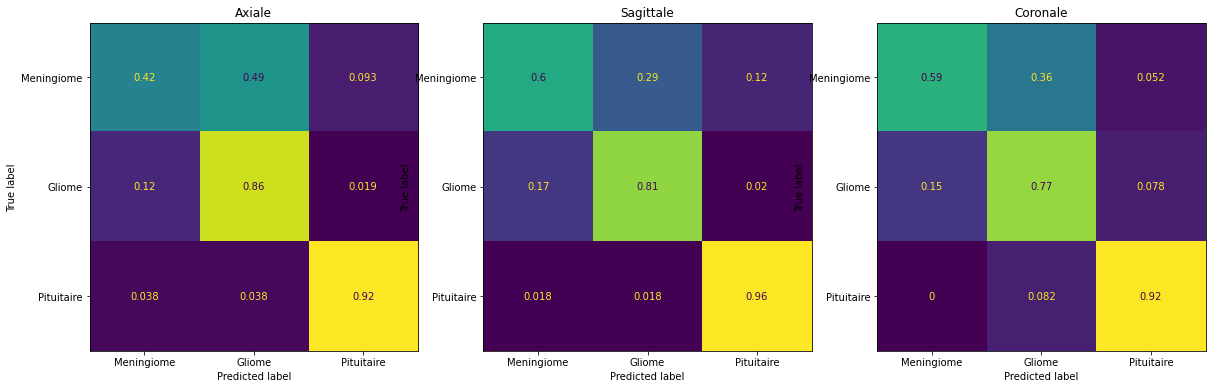

In [ ]:
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(model_forest_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(model_forest_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(model_forest_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

Après avoir rajouté les feature extrait de la matrice GCLM on observe une diminution de la précision du modèle. On peut donc se poser la question de la pertinance de tout ces features.

#Feature Selection

Dans cette partie on s'intéresse à la sélection de features, en effet le but est de réduire l'espace de features de manière à augmenter la précision du modèle.

<BarContainer object of 12 artists>

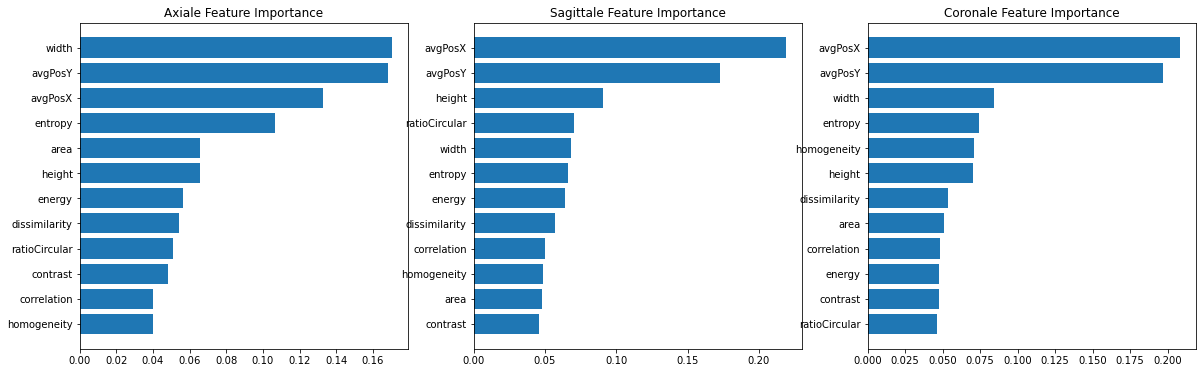

In [ ]:
f, axarr = plt.subplots(1,3)
f.set_size_inches(20, 6)

feature_names = X_Axiale.columns
sorted_idx_Axiale = model_forest_Axiale.feature_importances_.argsort()
sorted_idx_Sagittale = model_forest_Sagittale.feature_importances_.argsort()
sorted_idx_Coronale = model_forest_Coronale.feature_importances_.argsort()
axarr[0].set_title("Axiale Feature Importance")
axarr[1].set_title("Sagittale Feature Importance")
axarr[2].set_title("Coronale Feature Importance")
axarr[0].barh(feature_names[sorted_idx_Axiale], model_forest_Axiale.feature_importances_[sorted_idx_Axiale])
axarr[1].barh(feature_names[sorted_idx_Sagittale], model_forest_Sagittale.feature_importances_[sorted_idx_Sagittale])
axarr[2].barh(feature_names[sorted_idx_Coronale], model_forest_Coronale.feature_importances_[sorted_idx_Coronale])

On remarque que beaucoup des feature GCLM ne rajoutent pas grand chose au modèle, dans la prochaine partie on va essayer de voir lesquelles des features sont les plus important.

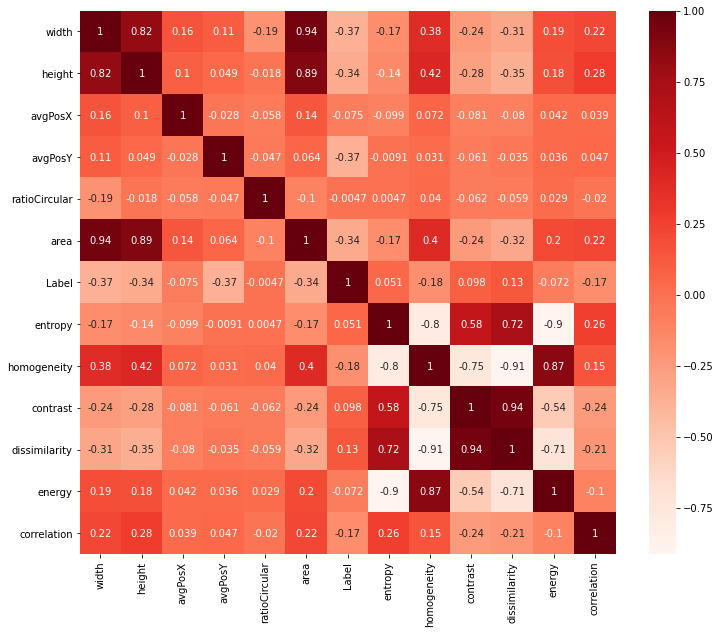

In [ ]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Ci-dessus la matrice de corrélation pour notre modèle sur les coupes Axiale. On remarque plusieurs choses : tout d'abord une forte corrélation entre `width` et `height` ce qui semble logique. D'autre part, on remarque une corrélation forte entre `Width`,`Height` et `area` ce qui est aussi logique. Enfin on remarque que les feaures extrait de la matrice GCLM ne sont plutôt pas corrélées ce qui pourrait aider à la classification.

In [ ]:
#Selection de features les trés corrélé avec le résultat
cor_target = abs(cor["Label"])
relevant_features = cor_target[cor_target>0.10]
relevant_features

width            0.371144
height           0.339086
avgPosY          0.372527
area             0.335676
Label            1.000000
homogeneity      0.177928
dissimilarity    0.134031
correlation      0.171084
Name: Label, dtype: float64

In [ ]:
import statsmodels.api as sm
X_Axiale_1 = sm.add_constant(X_Axiale)

model = sm.OLS(Y_Axiale,X_Axiale_1).fit()
model.pvalues

const            1.825276e-10
width            1.224037e-06
height           7.895994e-03
avgPosX          2.088846e-01
avgPosY          3.081811e-33
ratioCircular    2.163962e-03
area             4.519194e-03
entropy          8.736803e-02
homogeneity      3.819651e-02
contrast         7.492667e-01
dissimilarity    4.296455e-01
energy           6.280568e-03
correlation      1.287637e-02
dtype: float64

In [ ]:
#Cette fonction sert estimé les features qui sont important pour le modele donc a retiré les feature inutile
cols = list(X_Axiale.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_Axiale[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y_Axiale,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(cols)


['width', 'height', 'avgPosY', 'ratioCircular', 'area', 'entropy', 'homogeneity', 'dissimilarity', 'energy', 'correlation']


Cette fonction sert a retiré les feature qui donne peu d'information au modele, ci dessous l'array des heature "important":

`['width', 'height', 'avgPosY', 'ratioCircular', 'area', 'entropy', 'homogeneity', 'dissimilarity', 'energy', 'correlation']
`

In [ ]:
from sklearn.feature_selection import RFE
nof_list=np.arange(1,13)            
high_score=0
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_Axiale_test, y_train, y_test = train_test_split(X_Axiale,Y_Axiale, test_size = 0.2, random_state = 20)
    model = RandomForestClassifier(n_estimators=100,random_state=20)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_Axiale_test_rfe = rfe.transform(X_Axiale_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_Axiale_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]




In [ ]:
print("Nombre optimal de features: %d" %nof)
print("Score avec %d features: %f" % (nof, high_score))

Nombre optimal de features: 6
Score avec 6 features: 0.824121


In [ ]:
cols = list(X_Axiale.columns)
model = RandomForestClassifier(n_estimators=100,random_state=20)#Initializing RFE model
rfe = RFE(model, 6)             #Transforming data using RFE
X_Axiale_rfe = rfe.fit_transform(X_Axiale,Y_Axiale)  #Fitting the data to model
model.fit(X_Axiale_rfe,Y_Axiale)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index


In [ ]:
print(selected_features_rfe)

Index(['width', 'avgPosX', 'avgPosY', 'area', 'entropy', 'energy'], dtype='object')


Une fois que le nombre de feature optimisé est sélectionné il faut voir quelle combinaison de 6 features donne de bons résultats. Voici ci-joint la liste des feature sélectionnées pour optimiser le modèle:

`['width', 'avgPosX', 'avgPosY', 'area', 'entropy', 'energy']`

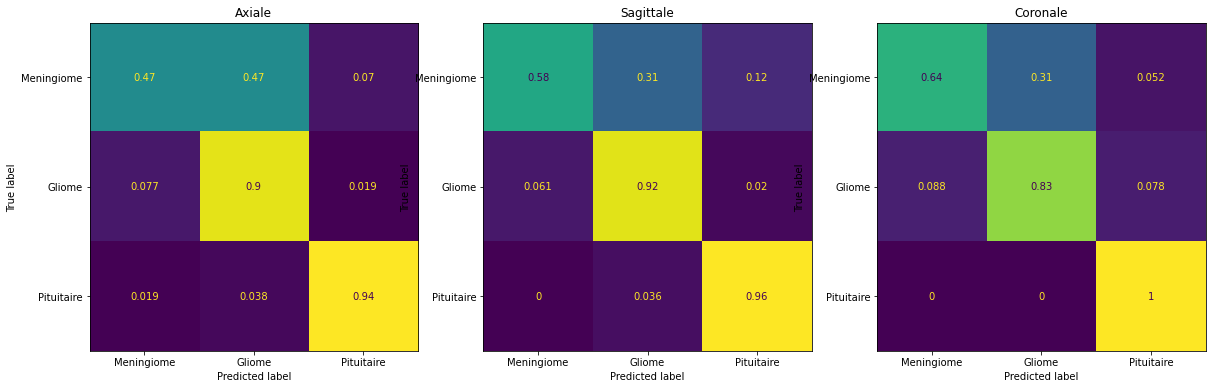

In [ ]:
X_Axiale = df.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Axiale = df['Label'].values
 
X_Sagittale = df_Sagittale.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Sagittale = df_Sagittale['Label'].values
 
X_Coronale = df_Coronale.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Coronale = df_Coronale['Label'].values
 
 
X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)
X_Sagittale_train,X_Sagittale_test,Y_Sagittale_train,Y_Sagittale_test = train_test_split(X_Sagittale,Y_Sagittale,test_size=0.20,random_state=20)
X_Coronale_train,X_Coronale_test,Y_Coronale_train,Y_Coronale_test = train_test_split(X_Coronale,Y_Coronale,test_size=0.20,random_state=20)
#Random Forest Coupe Axiale
bagging_Axiale = BaggingClassifier(         n_estimators=200,         n_jobs=n_jobs,         random_state=20)
bagging_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = bagging_Axiale.predict(X_Axiale_test)
 
#Random Forest Coupe Sagittale
bagging_Sagittale = BaggingClassifier(         n_estimators=200,         n_jobs=n_jobs,         random_state=20)
bagging_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = bagging_Sagittale.predict(X_Sagittale_test)
 
#Random Forest Coupe Coronale
bagging_Coronale = BaggingClassifier(         n_estimators=200,         n_jobs=n_jobs,         random_state=20)
bagging_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = bagging_Coronale.predict(X_Coronale_test)
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(bagging_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(bagging_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(bagging_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  



On remarque que le bagging n'apporte pas plus de précision comparé au random forest donc ce modéle reste plus cohérent.

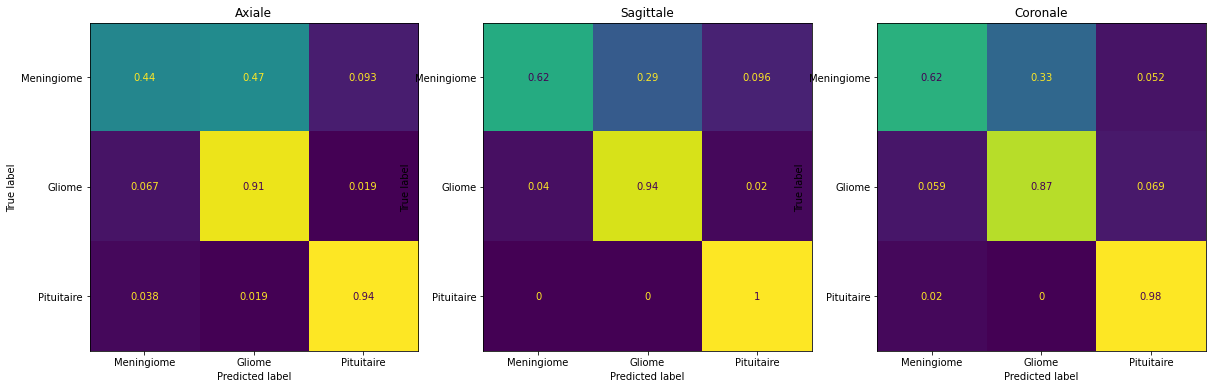

In [ ]:
X_Axiale = df.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Axiale = df['Label'].values
 
X_Sagittale = df_Sagittale.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Sagittale = df_Sagittale['Label'].values
 
X_Coronale = df_Coronale.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Coronale = df_Coronale['Label'].values
 
 
X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)
X_Sagittale_train,X_Sagittale_test,Y_Sagittale_train,Y_Sagittale_test = train_test_split(X_Sagittale,Y_Sagittale,test_size=0.20,random_state=20)
X_Coronale_train,X_Coronale_test,Y_Coronale_train,Y_Coronale_test = train_test_split(X_Coronale,Y_Coronale,test_size=0.20,random_state=20)
#Random Forest Coupe Axiale
model_forest_Axiale = RandomForestClassifier(n_estimators=200,random_state=20)
model_forest_Axiale.fit(X_Axiale_train,Y_Axiale_train)
prediction_test_Axiale = model_forest_Axiale.predict(X_Axiale_test)
 
#Random Forest Coupe Sagittale
model_forest_Sagittale = RandomForestClassifier(n_estimators=200,random_state=20)
model_forest_Sagittale.fit(X_Sagittale_train,Y_Sagittale_train)
prediction_test_Sagittale = model_forest_Sagittale.predict(X_Sagittale_test)
 
#Random Forest Coupe Coronale
model_forest_Coronale = RandomForestClassifier(n_estimators=200,random_state=20)
model_forest_Coronale.fit(X_Coronale_train,Y_Coronale_train)
prediction_test_Coronale = model_forest_Coronale.predict(X_Coronale_test)
fig, axses = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
plot_confusion_matrix(model_forest_Axiale, X_Axiale_test, Y_Axiale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[0],colorbar=False,normalize='true')  
axses[0].title.set_text('Axiale')  
plot_confusion_matrix(model_forest_Sagittale, X_Sagittale_test, Y_Sagittale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[1],colorbar=False,normalize='true')  
axses[1].title.set_text('Sagittale')  
plot_confusion_matrix(model_forest_Coronale, X_Coronale_test, Y_Coronale_test,display_labels=['Meningiome','Gliome','Pituitaire'],ax=axses[2],colorbar=False,normalize='true')  
axses[2].title.set_text('Coronale')  

In [ ]:
from sklearn.model_selection import cross_val_score

X_Axiale = df.drop(columns=['Label','correlation','ratioCircular','homogeneity', 'dissimilarity','correlation','height'],axis=1)
Y_Axiale = df['Label'].values
X_Axiale_train,X_Axiale_test,Y_Axiale_train,Y_Axiale_test = train_test_split(X_Axiale,Y_Axiale,test_size=0.20,random_state=20)

model_forest = RandomForestClassifier(n_estimators=100,random_state=20)
model_forest.fit(X_train,Y_Axiale_train)
importances = model_forest.feature_importances_
scores = cross_val_score(model_forest, X_train, Y_Axiale_train)
print(scores.mean())

0.830021495103893


#Conclusion

Les résultats qu'on obtient sont moyens, néanmoins on remarque que le modèle arrive facilement à différencier les `Gliome` et `Meningiome` des tumeurs `Pitulaire`. 
Alors que les `Gliome` et les `Meningiome` sont difficilement classifiés ceci s'explique par leur similarité. Les résultats obtenus sont satisfaisants car le modèle confond les `Meningiome` en `Gliome`.
Les `Gliome` sont des tumeurs très dangeureuses qu'il faut suivre en faisant des IRM régulièrement, les `Meningiome` n'évoluant pas seront donc diagnostiqués sur des IRM futures.
